<a href="https://colab.research.google.com/github/M-McKegney/ET5003_SEM1_2021-2/blob/MMcKegneyBranch/ET5003_Etivity2_MichaelMcKegney_20149743.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [167]:
#@title Current Date
Today = '2021-09-30' #@param {type:"date"}


In [168]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20149743" #@param {type:"string"}
Student_full_name = "Michael McKegney" #@param {type:"string"}
#@markdown ---

In [169]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [170]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [172]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [173]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Read in the dataset

**Be careful with the 'Path' location shown below i.e. make sure it is pointing to where you store the data for Etivity 2!**

The following code is being used to determine if a Jupyter Notebook or Google Colab environment is being used to load the dataset.

The development work for this Etivity was done in Google Colab.

There are 3 files to account for:
*   house_train.csv
*   house_test.csv
*   true_price.csv

In [174]:
# Checking if you are using Google Colab.

RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # paste the path here, keep quotation marks and the trailing slash
    Path = '/content/drive/MyDrive/UL_Colab_Files/ET5003/Etivity2/'
    
else:
    
    Path = './Etivity2/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read in each ".csv" file into a Pandas dataframe and print the shape of the data.

In [175]:
# Training Dataset: 
training_file = Path + 'house_train.csv'
dftrain = pd.read_csv(training_file)
print('House train data shape: ', dftrain.shape)

# Test Dataset:
testing_file = Path + 'house_test.csv'
dftest = pd.read_csv(testing_file)
print('House test data shape: ', dftest.shape)

# Cost Dataset:
cost_file = Path + 'true_price.csv'
dfcost = pd.read_csv(cost_file)
print('True price data shape: ', dfcost.shape)


House train data shape:  (2982, 17)
House test data shape:  (500, 16)
True price data shape:  (500, 2)


Check the initial rows and review some basic statistics for each dataframe.

## Training & Test Data

**Not using this for now...**

In [176]:
# # split data into training and test
# from sklearn.model_selection import train_test_split

# # training: 70% (0.7), test: 30% (0.3) 
# # you could try any other combination 
# # but consider 50% of training as the low boundary
# X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

### Train dataset

In [177]:
# Show first data frame rows.
dftrain.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [178]:
# Generate descriptive statistics.
dftrain.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


In [179]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982 entries, 0 to 2981
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ad_id               2982 non-null   int64  
 1   area                2982 non-null   object 
 2   bathrooms           2931 non-null   float64
 3   beds                2931 non-null   float64
 4   ber_classification  2305 non-null   object 
 5   county              2982 non-null   object 
 6   description_block   2982 non-null   object 
 7   environment         2982 non-null   object 
 8   facility            965 non-null    object 
 9   features            2982 non-null   object 
 10  latitude            2982 non-null   float64
 11  longitude           2982 non-null   float64
 12  no_of_units         59 non-null     float64
 13  price               2892 non-null   float64
 14  property_category   2982 non-null   object 
 15  property_type       2931 non-null   object 
 16  surfac

Check each column in the dataframe how many null/Nan instances there are.

In [180]:
dftrain.isna().sum()

ad_id                    0
area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

There is 2982 rows in the training data. 
*   '**facility**' has 2017 NaN instances which means there is nearly two thirds of values missing. 
*   '**no_of_units**' has 2923 NaN instances which means there is nearly all values missing.
*   '**ad_id**' has 2982 unique values which equates to the total amount of rows so it is not offering any helpful information.

These features will be dropped as there is not much value being added in terms of training a model with them.




In [181]:
dftrain_adj = dftrain.drop(columns=['ad_id', 'facility','no_of_units'])

dftrain_adj.head()
dftrain_adj.shape

(2982, 14)

Check how much variation there is in the feature '**county**'.

In [188]:
dftrain_adj['county'].value_counts()

Dublin    1989
Name: county, dtype: int64

As '**county**' has only one value i.e. 'Dublin', this feature can be removed.

In [189]:
dftrain.drop(columns=['county'], inplace=True)

In [191]:
dftrain['area'].value_counts()

Finglas           94
Castleknock       90
Rathfarnham       87
Malahide          81
Lucan             79
                  ..
Deansgrange        1
Coolmine           1
Cherry Orchard     1
Ballymount         1
Ard Na Greine      1
Name: area, Length: 156, dtype: int64

Drop all rows with NaN present as the sample/observation is incomplete and may be misleading.

In [182]:
dftrain_adj.dropna(inplace=True)

dftrain_adj.shape

(2002, 14)

Remove samples where there are 0 bathrooms and 0 bedrooms.

In [183]:
dftrain_adj.drop(dftrain_adj[dftrain_adj.beds == 0].index, inplace=True)

dftrain_adj.drop(dftrain_adj[dftrain_adj.bathrooms == 0].index, inplace=True)

dftrain_adj.shape

(1989, 14)

Use one-hot encoding to make the categorical variables now numeric.

In [184]:
dftrain_adj.dtypes

area                   object
bathrooms             float64
beds                  float64
ber_classification     object
county                 object
description_block      object
environment            object
features               object
latitude              float64
longitude             float64
price                 float64
property_category      object
property_type          object
surface               float64
dtype: object

In [187]:
dftrain_adj['county'].value_counts()

Dublin    1989
Name: county, dtype: int64

In [160]:
# area	ber_classification	county	description_block	environment	features	property_category	property_type

# 'description_block',	'area',

# dftrain_adj = pd.get_dummies(dftrain_adj, columns=[	'ber_classification',	'county',	'environment',	'features',	'property_category',	'property_type'], drop_first=True)



In [161]:
# dftrain_adj.head()

dftrain_adj.shape

(1989, 1482)

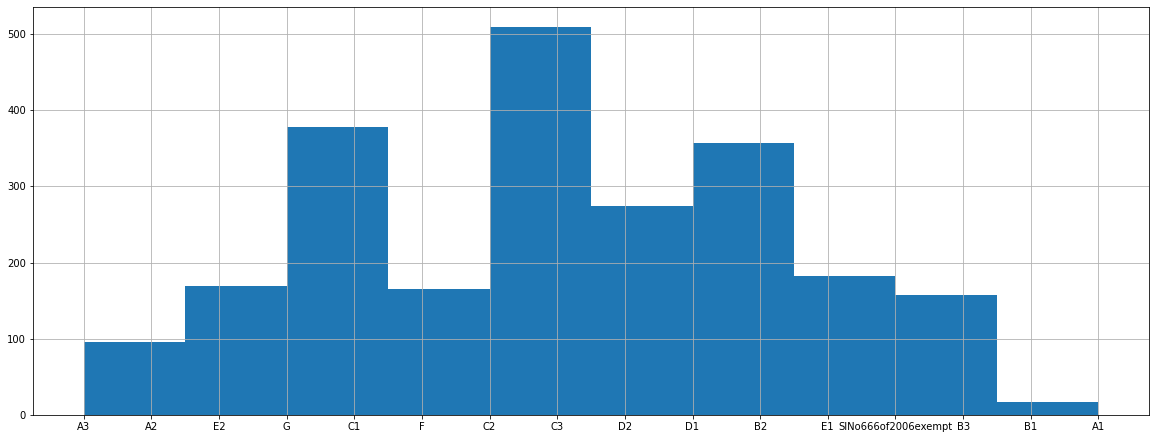

In [ ]:
dftrain_adj['ber_classification'].value_counts(dropna=False)

dftrain_adj['ber_classification'].hist(figsize=(20, 7.5))

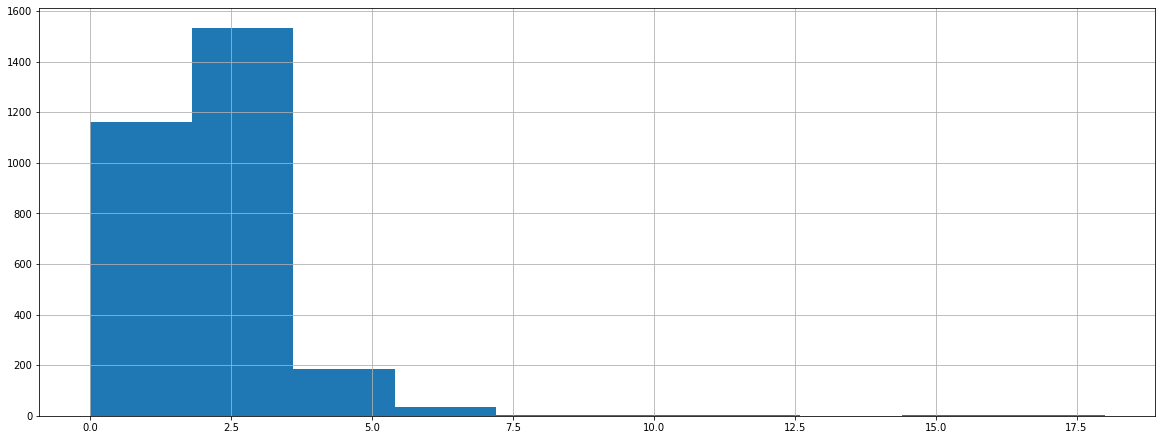

In [ ]:
dftrain_adj['bathrooms'].value_counts(dropna = False)

dftrain_adj['bathrooms'].hist(figsize=(20, 7.5))

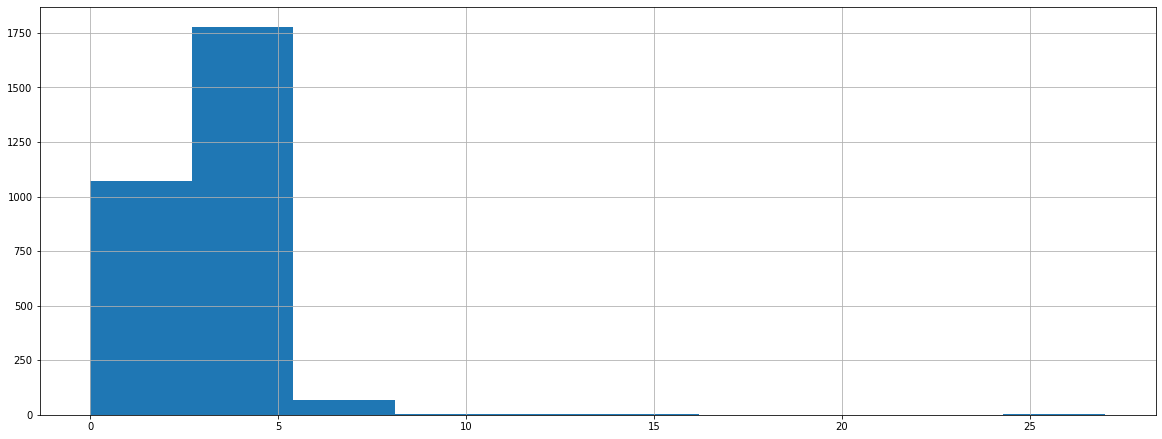

In [ ]:
dftrain_adj['beds'].value_counts(dropna = False)

dftrain_adj['beds'].hist(figsize=(20, 7.5))

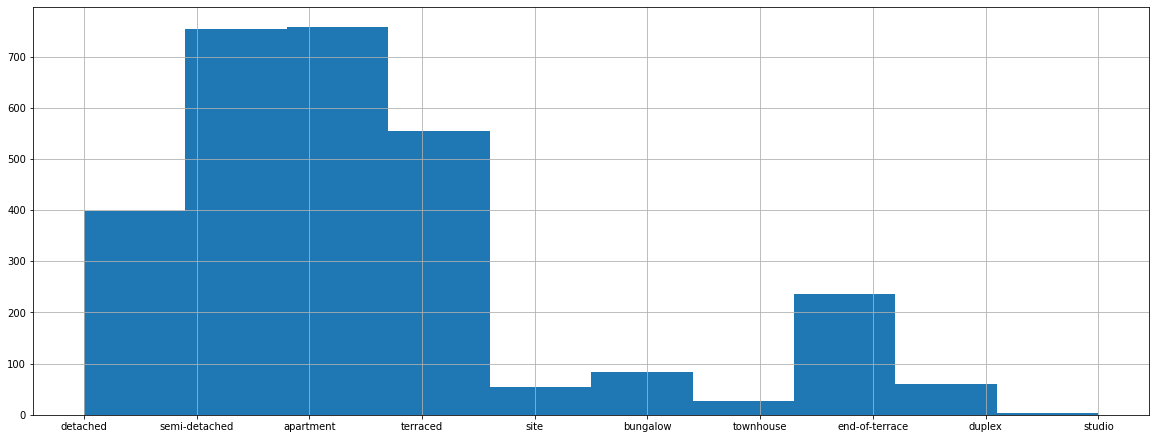

In [ ]:
dftrain_adj['property_type'].value_counts(dropna = False)

dftrain_adj['property_type'].hist(figsize=(20, 7.5))

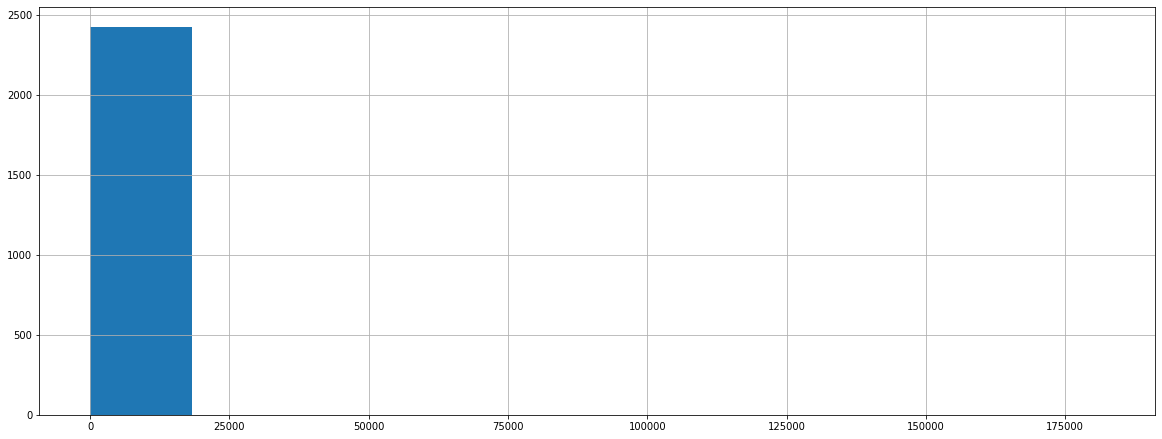

In [ ]:
dftrain_adj['surface'].value_counts(dropna = False)

dftrain_adj['surface'].hist(figsize=(20, 7.5))

### Test dataset

In [ ]:
# Show first data frame rows.
dftest.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


In [ ]:
# Generate descriptive statistics.
dftest.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,surface
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,0.0,500.000000
mean,1.231695e+07,1.994000,2.930000,53.356034,-6.247842,NaN,156.007671
std,1.485832e+05,1.106532,1.191612,0.081905,0.088552,NaN,344.497362
min,1.130615e+07,0.000000,0.000000,53.221348,-6.496987,NaN,33.500000
25%,1.228617e+07,1.000000,2.000000,53.297373,-6.296404,NaN,72.375000
50%,1.237964e+07,2.000000,3.000000,53.339547,-6.243572,NaN,98.000000
75%,1.240544e+07,3.000000,4.000000,53.381650,-6.185055,NaN,138.935000
max,1.242809e+07,8.000000,7.000000,53.619775,-6.064874,NaN,5746.536120


### Expected Cost dataset

In [ ]:
# Show first data frame rows.
dfcost.head()

,Id,Expected
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


In [ ]:
# Generate descriptive statistics.
dfcost.describe()

,Id,Expected
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


# PIECEWISE REGRESSION

## Full Model

In [ ]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['feature_1','feature_2','feature_3','cost']
# dropna: remove missing values
df_subset_train = dftrain[featrain].dropna(axis=0)

featest = ['feature_1','feature_2','feature_3']
df_subset_test  =  dftest[featest].dropna(axis=0)

# cost
df_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

In [ ]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

In [ ]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

## Clustering

### Full Model

In [ ]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)


### Clusters

In [ ]:
# train clusters



In [ ]:
# test clusters


## Piecewise Model

In [ ]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])



##Simulations

### Only Cluster 0

## Overall

## Test set performance

### PPC on the Test set



# SUMMARY